In [187]:
%matplotlib inline
import pylab as pl
import numpy as np
from scipy import stats
import scipy.io.wavfile as wavf
import os
import math
import sys
import soundfile as sf
from aubio import pitch

def makeMono(signal):
    finalSignal = []
    signal = signal.astype(np.float32)
    for s in signal:
        if isNumber(s):
            finalSignal.append(s)
        else:
            stereoMean = (s[0] + s[1]) / 2.0
            finalSignal.append(stereoMean)
            
    finalSignal = np.array(finalSignal)
        
    return finalSignal.astype(np.float32)

def isNumber(value):
    return not hasattr(value, "__len__")

def decisionTree(pitches):
    avr = np.mean(pitches)
    q25 = np.percentile(pitches, 25)
    q75 = np.percentile(pitches, 75)
    iqr = q75 - q25

    if avr >= 145:
        gender = 'K'
    elif iqr >= 135:
        gender = 'K'
    else:
        gender = 'M'
   
    return gender, avr, iqr

def analyze_wav(wav_file):
    wav_file = 'train/' + wav_file
    fileGender = wav_file[10]
    signal, samplerate = sf.read(wav_file)
    signal = makeMono(signal)
    
    win_s = 4096
    hop_s = 512
    pitch_o = pitch("yin", win_s, hop_s, samplerate)
    pitches = []
    i = 0
    size = 512
    n = len(signal)
    
    while size*(i+1) < n:
        samples = signal[(i*size):((i+1)*size)]
        pitch_sample  = pitch_o(samples)[0]
        if pitch_sample > 0 and pitch_sample < 280:
            pitches += [pitch_sample]
        i += 1
    
    gender, avr, iqr = decisionTree(pitches)
    print(wav_file + ' ~~~> ' + gender + ' ~~~> MEAN: ' + str(avr) + ' ~~~> IQR: ' + str(iqr) )
    if gender == fileGender:
        return 1
    print('NO')
    return 0


ImportError: cannot import name 'fftfreq'

057_K.wav
sampling rate: 44100 Hz
length: 207047 samples
channels: 2
sample width: 2 bytes
[[-2 -2]
 [-1 -1]
 [-1 -1]
 ..., 
 [ 0  0]
 [-1 -1]
 [-1 -1]]
257.992150649
end


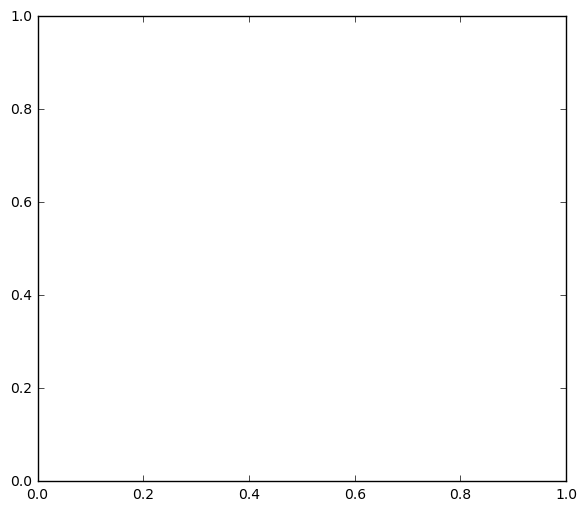

In [210]:
import wave
import matplotlib.pyplot as plt

if __name__ == '__main__':
#     for wav_file in os.listdir('train'):
#         try:
#             analyze_wav(wav_file)
#         except:
#             print(wav_file)
#             pass
    good = 0

    for wav_file in os.listdir('train')[:1]:
     #   try:
            print(wav_file)
            #sf.read('train/' + wav_file)
            w = wave.open('train/' + wav_file)
            framerate = w.getframerate()
            frames = w.getnframes()
            channels = w.getnchannels()
            width = w.getsampwidth()
            print('sampling rate:', framerate, 'Hz')
            print('length:', frames, 'samples')
            print('channels:', channels)
            print('sample width:', width, 'bytes')
            data = w.readframes(frames)

            sig = np.frombuffer(data, dtype='int16').reshape(-1, channels)
            print(sig)
            sig = sig /2**15
            #plt.plot(sig[:100000,0]/2**15)
            fig = plt.figure(figsize=(15, 6), dpi=80)
            ax =  fig.add_subplot(121)
            #ax.set_ylim(-10, 2100)
            #sig = np.frombuffer(data, dtype='2B').reshape(-1, channels)
            sig = sig[:,0]
            signal = np.fft.fft(sig)
            d = len(signal)/2
            spec = abs(signal[:int(d-1)])
            #freq = np.fft.fftfreq(len(spec))
            tab = []
            
            k = 0
            l = len(sig)
            while k < l - 4096:
                spec = np.fft.fft(sig[k:k+4096])
                freqs = np.fft.fftfreq(len(spec))
                idx = np.argmax(np.abs(spec))
                freq = freqs[idx]
                freq_in_hertz = abs(freq * framerate)
                if freq_in_hertz > 50 and freq_in_hertz <280:
                    tab = tab + [freq_in_hertz]
                k += 512
                
            print(np.mean(tab))
                
                
    print('end')